# Process Modeling 101 <a class="anchor" id="top"></a>

- **Prepared by:**
    
    - [Ga-Yeong Kim](https://qsdsan.readthedocs.io/en/latest/CONTRIBUTING.html)
    - [Joy Zhang](https://qsdsan.readthedocs.io/en/latest/CONTRIBUTING.html)
    
- **Covered topics:**

    - [1. Introduction](#s1)
    - [2. System Setup](#s2)
    - [3. System Simulation](#s3)
    
To run tutorials in your browser, go to this [Binder page](https://mybinder.org/v2/gh/QSD-Group/QSDsan-env/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252FQSD-group%252FQSDsan%26urlpath%3Dtree%252FQSDsan%252Fdocs%252Fsource%252Ftutorials%26branch%3Dmain).

In [1]:
import qsdsan as qs
print(f'This tutorial was made with qsdsan v{qs.__version__}.')

This tutorial was made with qsdsan v1.3.1.


In [2]:
# Import packages
import numpy as np, pandas as pd
from qsdsan import sanunits as su, processes as pc, WasteStream, System
from qsdsan.utils import time_printer, load_data, get_SRT

import warnings
warnings.filterwarnings('ignore')             # to ignore Pandas future warning & NumbaPerformanceWarning

## 1. Introduction <a class="anchor" id="s1"></a>

In this tutorial, we will explore how each QSDsan class is used in **practical process simulation**. 

For this purpose, we will utilize **an example system** consisting of five-compartment activated sludge reactor followed by a flat-bottom circular clarifier. In addition, as a process model, **Activated Sludge Model No. 2d (ASM2d)** will be employed.

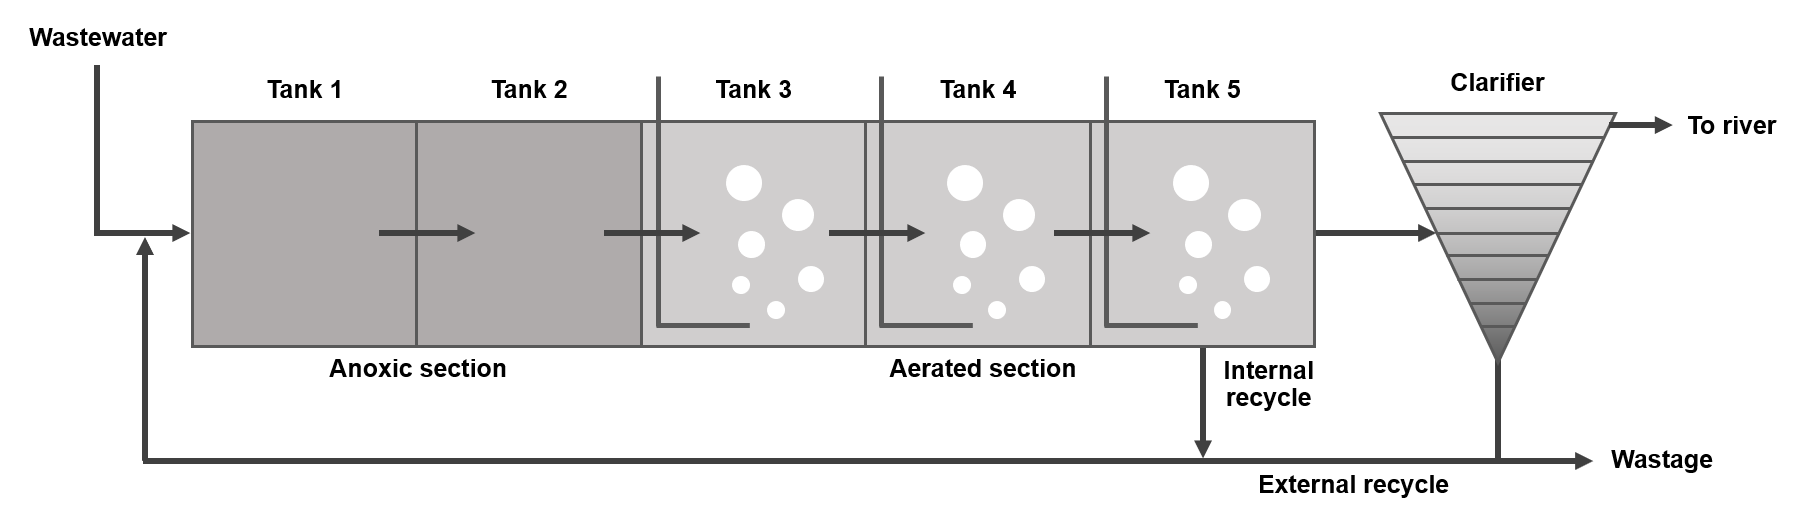

[Back to top](#top)

## 2. System Setup <a class="anchor" id="s2"></a>

### 2.1. `Component`

Chemicals or biomass existing in a system can be expressed using the `Component` class of QSDsan.

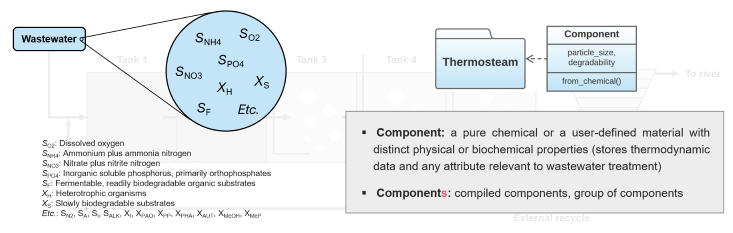

In [3]:
# Components 
cmps = pc.create_asm2d_cmps()           # create components of ASM2d 
                                        # you don't need to define each component one by one. 
                                        # compiled components for ASM2d are already available.
        
cmps.show()                             # 18 components of ASM2d + water (X_TSS was excluded due to redundancy.)

CompiledComponents([S_O2, S_N2, S_NH4, S_NO3, S_PO4, S_F, S_A, S_I, S_ALK, X_I, X_S, X_H, X_PAO, X_PP, X_PHA, X_AUT, X_MeOH, X_MeP, H2O])


**S_O2**: Dissolved oxygen, **S_N2**: Dinitrogen, **S_NH4**: Ammonium plus ammonia nitrogen, **S_NO3**: Nitrate plus nitrite nitrogen (NO3-N + NO2-N), **S_PO4**: Inorganic soluble phosphorus, primarily orthophosphates, **S_F**: Fermentable, readily biodegradable organic substrates, **S_A**: Fermentation products, considered to be acetate, **S_I**: Inert soluble organic
material, **S_ALK**: Alkalinity of the wastewater, **X_I**: Inert particulate organic material, **X_S**: Slowly biodegradable substrates, **X_H**: Heterotrophic organisms, **X_PAO**: Phosphate-accumulating organisms, PAO, **X_PP**: Poly-phosphate, **X_PHA**: A cell internal storage product of phosphorus-accumulating organisms, PAO, **X_AUT**: Nitrifying organisms, **X_MeOH**: Metal-hydroxides, **X_MeP**: Metal-phosphate, MePO4

In [4]:
cmps.S_A.show(chemical_info=True)              # each component stores thermodynamic properties.

Component: S_A (phase_ref='l')
[Names]  CAS: 71-50-1
         InChI: InChI=1S/C2H4O2/c1-2...
         InChI_key: QTBSBXVTEAMEQO-U...
         common_name: Acetic acid, i...
         iupac_name: ('acetate',)
         pubchemid: 175
         smiles: CC(=O)[O-]
         formula: C2H3O2-
[Groups] Dortmund: <Empty>
         UNIFAC: <Empty>
         PSRK: <Empty>
         NIST: <Empty>
[Data]   MW: 59.044 g/mol
         Tm: None
         Tb: 626.15 K
         Tt: None
         Tc: None
         Pt: None
         Pc: None
         Vc: 0.00016858 m^3/mol
         Hf: 0 J/mol
         S0: 0 J/K/mol
         LHV: 0 J/mol
         HHV: 0 J/mol
         Hfus: 0 J/mol
         Sfus: 0
         omega: None
         dipole: None
         similarity_variable: 0.11856
         iscyclic_aliphatic: 0
         combustion: {'CO2': 2, 'O2'...
Component-specific properties:
[Others] measured_as: COD
         description: Acetate
         particle_size: Soluble
         degradability: Readily
         organic

### 2.2. `WasteStream`

Mass and energy flow within the system can be represented using the `WastStream` class of QSDsan.

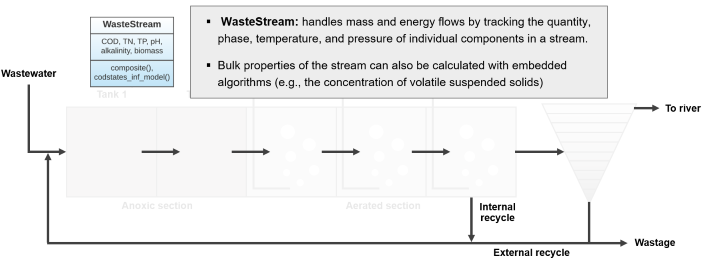

In [5]:
# Parameters (flowrates, temperature)
Q_inf = 18446                               # influent flowrate [m3/d]
Q_was = 385                                 # sludge wastage flowrate [m3/d]
Q_ext = 18446                               # external recycle flowrate [m3/d]
                                            # internal recycle flowrate will be defined later using split ratio.
                                            # effluent flowrate will be calculated as the amount remaining after recycling and wastage. 

Temp = 273.15+20                            # temperature [K]

In [6]:
# Create influent, effluent, recycle stream
influent = WasteStream('influent', T=Temp)                         # create an empty wastestream with specified temperature
effluent = WasteStream('effluent', T=Temp)

int_recycle = WasteStream('internal_recycle', T=Temp)
ext_recycle = WasteStream('external_recycle', T=Temp)
wastage = WasteStream('wastage', T=Temp)                           # streams between the reactors will be 
                                                                   # automatically assigned when we define SanUnit.

In [7]:
# Set the influent composition
default_inf_kwargs = {                                             # default influent composition
    'concentrations': {                                            # you can set concentration of each component separately.
      'S_I': 14,
      'X_I': 26.5,
      'S_F': 20.1,
      'S_A': 94.3,
      'X_S': 409.75,
      'S_NH4': 31,
      'S_N2': 0,
      'S_NO3': 0.266, 
      'S_PO4': 2.8,
      'X_PP': 0.05,
      'X_PHA': 0.5,
      'X_H': 0.15,
      'X_AUT': 0, 
      'X_PAO': 0, 
      'S_ALK':7*12,
      },
    'units': ('m3/d', 'mg/L'),                                     # ('input total flowrate', 'input concentrations')
    }                                                            

influent.set_flow_by_concentration(Q_inf, **default_inf_kwargs)    # set flowrate and composition of empty influent WasteStream

In [8]:
influent                               # wastestream stores bulk properties of the stream, as well as concentration of each component.

WasteStream: influent
phase: 'l', T: 293.15 K, P: 101325 Pa
flow (g/hr): S_NH4  2.38e+04
             S_NO3  204
             S_PO4  2.15e+03
             S_F    1.54e+04
             S_A    7.25e+04
             S_I    1.08e+04
             S_ALK  6.46e+04
             X_I    2.04e+04
             X_S    3.15e+05
             X_H    115
             X_PP   38.4
             X_PHA  384
             H2O    7.67e+08
 WasteStream-specific properties:
  pH         : 7.0
  Alkalinity : 2.5 mg/L
  COD        : 565.3 mg/L
  BOD        : 320.1 mg/L
  TC         : 271.4 mg/L
  TOC        : 187.4 mg/L
  TN         : 48.9 mg/L
  TP         : 7.4 mg/L
  TK         : 0.1 mg/L
 Component concentrations (mg/L):
  S_NH4   31.0
  S_NO3   0.3
  S_PO4   2.8
  S_F     20.1
  S_A     94.3
  S_I     14.0
  S_ALK   84.0
  X_I     26.5
  X_S     409.8
  X_H     0.2
  X_PP    0.1
  X_PHA   0.5
  H2O     997659.6


In [9]:
influent.get_VSS()                     # you can also retreive other information, such as VSS, TSS, TDS, etc.

324.98437505925017

### 2.3. `Process`

Chemical or biological reactions occurring within the system can be included
using the `Process` class of QSDsan.

### 2.3.1. Aeration 

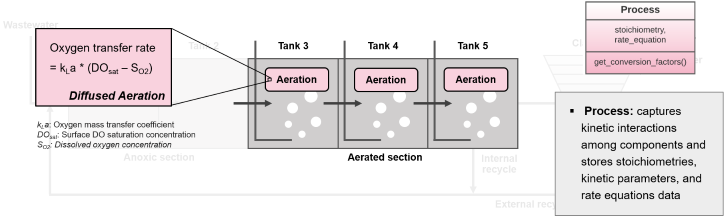

In [10]:
# Parameters (volumes)
V_an = 1000                                 # anoxic zone tank volume [m3/d]
V_ae = 1333                                 # aerated zone tank volume [m3/d]

In [11]:
# Aeration model
aer1 = pc.DiffusedAeration('aer1', DO_ID='S_O2', KLa=240, DOsat=8.0, V=V_ae)             # aeration model for Tank 3 & Tank 4
aer2 = pc.DiffusedAeration('aer2', DO_ID='S_O2', KLa=84, DOsat=8.0, V=V_ae)              # aeration model for Tank 5

**DO_ID:** The component ID of dissolved oxygen (DO).<br>
**KLa:** Oxygen mass transfer coefficient.<br>
**DOsat:** Surface DO saturation concentration.<br>
**V:** Reactor volume

In [12]:
aer1

Process: aer1
[stoichiometry]      S_O2: 1
[reference]          S_O2
[rate equation]      KLa*(DOsat - S_O2)
[parameters]         KLa: 240
                     DOsat: 8
[dynamic parameters] 


### 2.3.2. ASM2d

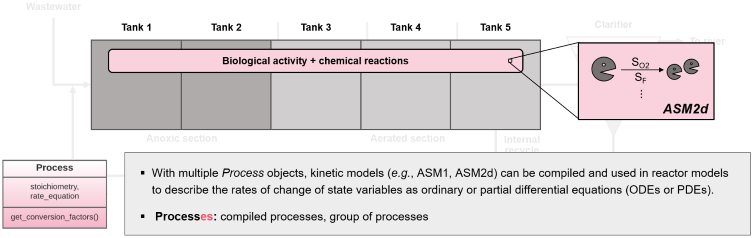

In [13]:
# ASM2d 
asm2d = pc.ASM2d()                       # create ASM2d processes
asm2d.show()                             # 21 processes in ASM2d

ASM2d([aero_hydrolysis, anox_hydrolysis, anae_hydrolysis, hetero_growth_S_F, hetero_growth_S_A, denitri_S_F, denitri_S_A, ferment, hetero_lysis, PAO_storage_PHA, aero_storage_PP, PAO_aero_growth_PHA, PAO_lysis, PP_lysis, PHA_lysis, auto_aero_growth, auto_lysis, precipitation, redissolution, anox_storage_PP, PAO_anox_growth])


In [14]:
asm2d.aero_hydrolysis                    # Each process includes stoichiometry, rate equation, and parameters.

Process: aero_hydrolysis
[stoichiometry]      S_NH4: 0.02*f_SI + 0.01
                     S_PO4: 0.01*f_SI
                     S_F: 1.0 - 1.0*f_SI
                     S_I: 1.0*f_SI
                     S_ALK: 0.0113*f_SI + 0.00858
                     X_S: -1.00
[reference]          X_S
[rate equation]      K_h*S_O2*X_S/((K_O2 + S_O2)*...
[parameters]         f_SI: 0
                     Y_H: 0.625
                     f_XI_H: 0.1
                     Y_PAO: 0.625
                     Y_PO4: 0.4
                     Y_PHA: 0.2
                     f_XI_PAO: 0.1
                     Y_A: 0.24
                     f_XI_AUT: 0.1
                     K_h: 3
                     eta_NO3: 0.6
                     eta_fe: 0.4
                     K_O2: 0.2
                     K_NO3: 0.5
                     K_X: 0.1
                     mu_H: 6
                     q_fe: 3
                     eta_NO3_H: 0.8
                     b_H: 0.4
                     K_O2_H: 0.2
                  

In [15]:
# Petersen stoichiometric matrix of ASM2d
pd.set_option('display.max_columns', None)                  # to display all columns

asm2d.stoichiometry

,S_O2,S_N2,S_NH4,S_NO3,S_PO4,S_F,S_A,S_I,S_ALK,X_I,X_S,X_H,X_PAO,X_PP,X_PHA,X_AUT,X_MeOH,X_MeP,H2O
aero_hydrolysis,0,0,0.01,0,0,1,0,0,0.00857,0,-1,0,0,0,0,0,0,0,0
anox_hydrolysis,0,0,0.01,0,0,1,0,0,0.00857,0,-1,0,0,0,0,0,0,0,0
anae_hydrolysis,0,0,0.01,0,0,1,0,0,0.00857,0,-1,0,0,0,0,0,0,0,0
hetero_growth_S_F,-0.6,0,-0.022,0,-0.004,-1.6,0,0,-0.0165,0,0,1,0,0,0,0,0,0,0
hetero_growth_S_A,-0.6,0,-0.07,0,-0.02,0,-1.6,0,0.252,0,0,1,0,0,0,0,0,0,0
denitri_S_F,0,0.21,-0.022,-0.21,-0.004,-1.6,0,0,0.164,0,0,1,0,0,0,0,0,0,0
denitri_S_A,0,0.21,-0.07,-0.21,-0.02,0,-1.6,0,0.432,0,0,1,0,0,0,0,0,0,0
ferment,0,0,0.03,0,0.01,-1,1,0,-0.168,0,0,0,0,0,0,0,0,0,0
hetero_lysis,0,0,0.032,0,0.01,0,0,0,0.0216,0.1,0.9,-1,0,0,0,0,0,0,0
PAO_storage_PHA,0,0,0,0,0.4,0,-1,0,0.11,0,0,0,0,-0.4,1,0,0,0,0


In [16]:
# Rate equations of ASM2d
asm2d.rate_equations

,rate_equation
aero_hydrolysis,3.0*S_O2*X_S/((0.1 + X_S/X_H)*(...
anox_hydrolysis,0.36*S_NO3*X_S/((0.1 + X_S/X_H)...
anae_hydrolysis,0.12*X_S/((0.1 + X_S/X_H)*(S_NO...
hetero_growth_S_F,6.0*S_ALK*S_F**2*S_NH4*S_O2*S_P...
hetero_growth_S_A,6.0*S_A**2*S_ALK*S_NH4*S_O2*S_P...
denitri_S_F,0.96*S_ALK*S_F**2*S_NH4*S_NO3*S...
denitri_S_A,0.96*S_A**2*S_ALK*S_NH4*S_NO3*S...
ferment,0.3*S_ALK*S_F*X_H/((S_ALK + 1.2...
hetero_lysis,0.4*X_H
PAO_storage_PHA,3.0*S_A*S_ALK*X_PP/((0.01 + X_P...


### 2.4. `SanUnit`

Reactors constituting the system can be represented using the `SanUnit` class of QSDsan.

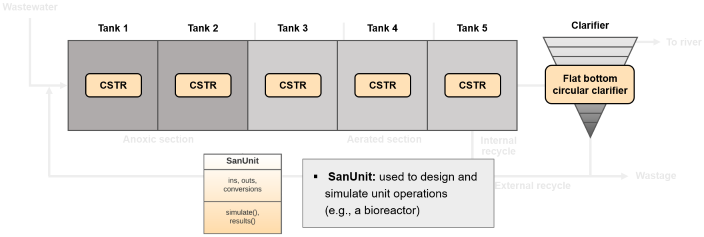

In [17]:
# Anoxic reactors (Tank 1 & Tank 2)
A1 = su.CSTR('A1', ins=[influent, int_recycle, ext_recycle], V_max=V_an,      # As CSTR, 3 input streams, tank volume as V_an
             aeration=None, suspended_growth_model=asm2d)                     # No aeration, biokinetic model as asm2d
    
A2 = su.CSTR('A2', ins=A1-0, V_max=V_an,                 # ins=A1-0: set influent of A2 as effluent of A1 reactor (to connect A1 with A2)
             aeration=None, suspended_growth_model=asm2d)

**ins:** Influents to the reactor.<br>
**outs:** Treated effluent from the reactor.<br>
**V_max:** Designed volume, in [m^3]. The default is 1000.<br>
**aeration:** Aeration setting. Either specify a targeted dissolved oxygen concentration in [mg O2/L] or provide a :class:`Process` object to represent aeration, or None for no aeration. The default is 2.0.<br>
**suspended_growth_model:** The suspended growth biokinetic model. The default is None.

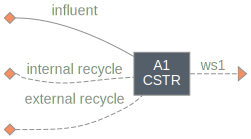

CSTR: A1
ins...
[0] influent
phase: 'l', T: 293.15 K, P: 101325 Pa
flow (g/hr): S_NH4  2.38e+04
                S_NO3  204
                S_PO4  2.15e+03
                S_F    1.54e+04
                S_A    7.25e+04
                S_I    1.08e+04
                S_ALK  6.46e+04
                X_I    2.04e+04
                X_S    3.15e+05
                X_H    115
                X_PP   38.4
                X_PHA  384
                H2O    7.67e+08
    WasteStream-specific properties:
     pH         : 7.0
     COD        : 565.3 mg/L
     BOD        : 320.1 mg/L
     TC         : 271.4 mg/L
     TOC        : 187.4 mg/L
     TN         : 48.9 mg/L
     TP         : 7.4 mg/L
     TK         : 0.1 mg/L
[1] internal_recycle
phase: 'l', T: 293.15 K, P: 101325 Pa
flow: 0
    WasteStream-specific properties: None for empty waste streams
[2] external_recycle
phase: 'l', T: 293.15 K, P: 101325 Pa
flow: 0
    WasteStream-specific properties: None for empty waste streams
outs...
[0] ws1 

In [18]:
A1                                        # Before simulation, outs are empty.

In [19]:
# Aerated reactors (Tank 3, Tank 4, Tank 5)
O1 = su.CSTR('O1', ins=A2-0, V_max=V_ae, aeration=aer1,                          # tank volume as V_ae with aeration model1
             DO_ID='S_O2', suspended_growth_model=asm2d)
    
O2 = su.CSTR('O2', ins=O1-0, V_max=V_ae, aeration=aer1,
             DO_ID='S_O2', suspended_growth_model=asm2d)
    
O3 = su.CSTR('O3', ins=O2-0, outs=[int_recycle, 'treated'], split=[0.6, 0.4],    # 60% of efflunet to internal recycle, 40% to clarifier
             V_max=V_ae, aeration=aer2,
             DO_ID='S_O2', suspended_growth_model=asm2d)

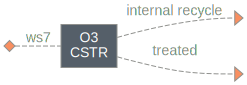

CSTR: O3
ins...
[0] ws7  from  CSTR-O2
phase: 'l', T: 298.15 K, P: 101325 Pa
flow: 0
    WasteStream-specific properties: None for empty waste streams
outs...
[0] internal_recycle  to  CSTR-A1
phase: 'l', T: 293.15 K, P: 101325 Pa
flow: 0
    WasteStream-specific properties: None for empty waste streams
[1] treated
phase: 'l', T: 298.15 K, P: 101325 Pa
flow: 0
    WasteStream-specific properties: None for empty waste streams


In [20]:
O3

In [21]:
# Clarifier
C1 = su.FlatBottomCircularClarifier('C1', ins=O3-1, outs=[effluent, ext_recycle, wastage],  # O3-1: second effluent of O3, three outs
                                    underflow=Q_ext, wastage=Q_was, surface_area=1500,
                                    height=4, N_layer=10, feed_layer=5,                     # modeled as a 10 layer non-reactive unit
                                    X_threshold=3000, v_max=474, v_max_practical=250,
                                    rh=5.76e-4, rp=2.86e-3, fns=2.28e-3)

**underflow:** Designed recycling sludge flowrate (RAS), in [m^3/d]. The default is 2000.<br>
**wastage:** Designed wasted sludge flowrate (WAS), in [m^3/d]. The default is 385.<br>
**surface_area:** Surface area of the clarifier, in [m^2]. The default is 1500.<br>
**height:** Height of the clarifier, in [m]. The default is 4.<br>
**N_layer:** The number of layers to model settling. The default is 10.<br>
**feed_layer:** The feed layer counting from top to bottom. The default is 4.<br>
**X_threshold:** Threshold suspended solid concentration, in [g/m^3]. The default is 3000.<br>
**v_max:** Maximum theoretical (i.e. Vesilind) settling velocity, in [m/d]. The default is 474.<br>
**v_max_practical:** Maximum practical settling velocity, in [m/d]. The default is 250.<br>
**rh:** Hindered zone settling parameter in the double-exponential settling velocity function, in [m^3/g]. The default is 5.76e-4.<br>
**rp:** Flocculant zone settling parameter in the double-exponential settling velocity function, in [m^3/g]. The default is 2.86e-3.<br>
**fns:** Non-settleable fraction of the suspended solids, dimensionless. Must be within [0, 1]. The default is 2.28e-3.

### 2.5. `System`

`System` objects are used to organize unit operations in a certain order and facilitate mass and energy convergence, techno-economic analysis (TEA), and life cycle assessment (LCA).

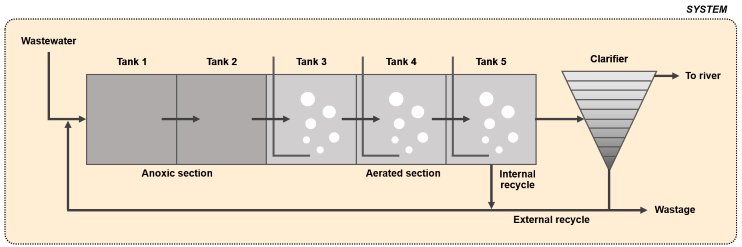

### 2.5.1. Create system

In [22]:
# Create system
sys = System('example_system', path=(A1, A2, O1, O2, O3, C1), recycle=(int_recycle, ext_recycle))     # path: the order of reactor

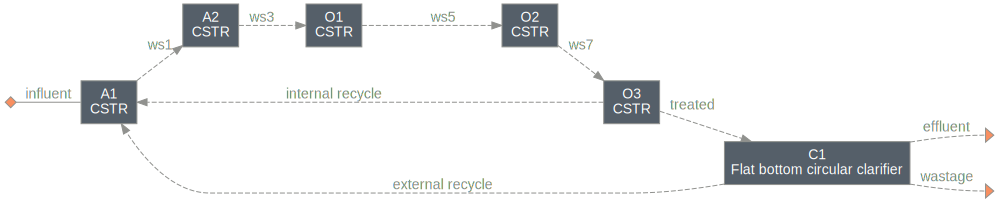

In [23]:
# System diagram
sys.diagram()

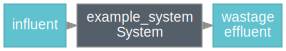

System: example_system
ins...
[0] influent  
    phase: 'l', T: 293.15 K, P: 101325 Pa
    flow (kmol/hr): S_NH4  1.32
                    S_NO3  0.0033
                    S_PO4  0.0112
                    S_F    15.4
                    S_A    1.23
                    S_I    10.8
                    S_ALK  1.06
                    ...    4.29e+04
outs...
[0] effluent  
    phase: 'l', T: 293.15 K, P: 101325 Pa
    flow: 0
[1] wastage  
    phase: 'l', T: 293.15 K, P: 101325 Pa
    flow: 0


In [24]:
sys                                                       # before running the simulation, 'outs' have nothing

### 2.5.2. Set initial conditions of reactors

In [25]:
# Import initial condition excel file
df = load_data('assets/tutorial_13/initial_conditions_asm2d.xlsx', sheet='default')

In [26]:
df                                                 # Unlike other reactors, C1 has 3 rows for each of soluble, solids, and tss.

,S_O2,S_NH4,S_NO3,S_PO4,S_F,S_A,S_I,S_ALK,X_I,X_S,X_H,X_PAO,X_PP,X_PHA,X_AUT
A1,0.00213,7.23,10.2,4.45,0.211,0.0265,15.9,67,2.28e+03,84.4,3.78e+03,322,37.2,0.0517,218
A2,0.001,22.4,2.4,4.24,6.68,53.8,14.5,79,0,84.1,207,18.2,4.25,3.59,11.9
O2,2,16.5,4.31,5.48,1.9,2.73,13.7,82.6,611,77.3,1.04e+03,86.4,6.45,11,58
O3,2,10.9,9.31,2.62,0.649,0.163,14.1,74.2,662,59.3,1.14e+03,95.7,9.99,7.24,64
O1,2,0.111,26.1,2.32,0.276,0.00407,18.2,46.1,2.24e+03,61.1,3.79e+03,322,38.4,0.00852,218
C1_s,2,0.114,20.9,0.356,0.307,0.00537,20.1,49.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C1_x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.24e+03,61.1,3.79e+03,322,38.4,0.00852,218
C1_tss,17.8,27.9,44.9,90.5,305,304,306,304,304,5.83e+03,NaN,NaN,NaN,NaN,NaN


In [27]:
# Create a function to set initial conditions of the reactors
def batch_init(sys, df):
    dct = df.to_dict('index')                                         # convert the DataFrame to a dictionary.
    u = sys.flowsheet.unit                                            # unit registry (A1, A2, O1, O2, O3, C1)
    
    for k in [u.A1, u.A2, u.O1, u.O2, u.O3]:                          # for A1, A2, O1, O2, O3 reactor,
        k.set_init_conc(**dct[k._ID])                                 # A1.set_init_conc(**dct[k_ID])        

    c1s = {k:v for k,v in dct['C1_s'].items() if v>0}                # for clarifier, need to use different methods
    c1x = {k:v for k,v in dct['C1_x'].items() if v>0}
    tss = [v for v in dct['C1_tss'].values() if v>0]
    u.C1.set_init_solubles(**c1s)                                     # set solubles
    u.C1.set_init_sludge_solids(**c1x)                                # set sludge solids
    u.C1.set_init_TSS(tss)                                            # set TSS

In [28]:
batch_init(sys, df)

[Back to top](#top)

## 3. System Simulation <a class="anchor" id="s3"></a>

### 3.1. Run simulation

In [29]:
# Simulation settings
sys.set_dynamic_tracker(influent, effluent, A1, A2, O1, O2, O3, C1, wastage)           # what you want to track changes in concentration
sys.set_tolerance(rmol=1e-6)

biomass_IDs = ('X_H', 'X_PAO', 'X_AUT')

In [30]:
# Simulation settings
t = 50                          # total time for simulation
t_step = 1                      # times at which to store the computed solution              

method = 'BDF'                  # integration method to use
# method = 'RK45'
# method = 'RK23'
# method = 'DOP853'
# method = 'Radau'
# method = 'LSODA'

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

In [31]:
# Run simulation, this could take several minuates
sys.simulate(state_reset_hook='reset_cache',
             t_span=(0,t),
             t_eval=np.arange(0, t+t_step, t_step),
             method=method,
            # export_state_to=f'sol_{t}d_{method}.xlsx',               # uncomment to export simulation result as excel file
            )

In [32]:
srt = get_SRT(sys, biomass_IDs)
print(f'Estimated SRT assuming at steady state is {round(srt, 2)} days')

Estimated SRT assuming at steady state is 10.02 days


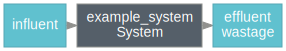

System: example_system
Highest convergence error among components in recycle
streams {C1-1, O3-0} after 5 loops:
- flow rate   1.46e-11 kmol/hr (5.2e-14%)
- temperature 0.00e+00 K (0%)
ins...
[0] influent  
    phase: 'l', T: 293.15 K, P: 101325 Pa
    flow (kmol/hr): S_NH4  1.32
                    S_NO3  0.0033
                    S_PO4  0.0112
                    S_F    15.4
                    S_A    1.23
                    S_I    10.8
                    S_ALK  1.06
                    ...    4.29e+04
outs...
[0] effluent  
    phase: 'l', T: 293.15 K, P: 101325 Pa
    flow (kmol/hr): S_O2   0.000505
                    S_N2   0.00716
                    S_NH4  1.54
                    S_NO3  2.28e-09
                    S_PO4  0.015
                    S_F    0.973
                    S_A    0.113
                    ...    4.17e+04
[1] wastage  
    phase: 'l', T: 293.15 K, P: 101325 Pa
    flow (kmol/hr): S_O2   1.08e-05
                    S_N2   0.000153
                    

In [33]:
sys                                                                      # now you have 'outs' info.

### 3.2. Check simulation results

(<Figure size 800x450 with 1 Axes>,
 <Axes: xlabel='Time [d]', ylabel='Concentration [mg/L]'>)

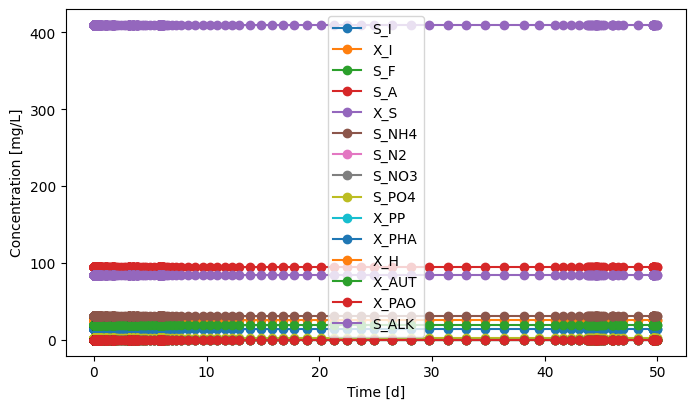

In [34]:
# Influent
influent.scope.plot_time_series(('S_I','X_I','S_F','S_A','X_S','S_NH4','S_N2','S_NO3','S_PO4','X_PP','X_PHA',
                                 'X_H','X_AUT','X_PAO','S_ALK'))      # you can plot how each state variable changes over time

#default_inf_kwargs = {                                            
#    'concentrations': {                                            
#      'S_I': 14,
#      'X_I': 26.5,
#      'S_F': 20.1,
#      'S_A': 94.3,
#      'X_S': 409.75,
#      'S_NH4': 31,
#      'S_N2': 0,
#      'S_NO3': 0.266, 
#      'S_PO4': 2.8,
#      'X_PP': 0.05,
#      'X_PHA': 0.5,
#      'X_H': 0.15,
#      'X_AUT': 0, 
#      'X_PAO': 0, 
#      'S_ALK':7*12,
#      },
#    'units': ('m3/d', 'mg/L'),                                    
#    }                                                               # constant influent setting

(<Figure size 800x450 with 1 Axes>,
 <Axes: xlabel='Time [d]', ylabel='Concentration [mg/L]'>)

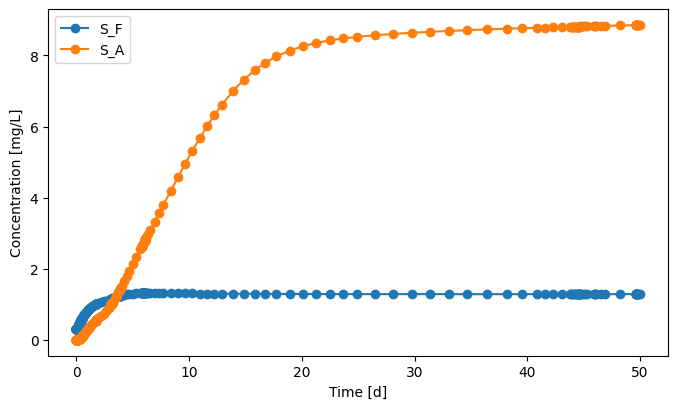

In [35]:
# Effluent
effluent.scope.plot_time_series(('S_F','S_A'))                   # you can plot how each state variable changes over time

(<Figure size 800x450 with 1 Axes>,
 <Axes: xlabel='Time [d]', ylabel='Concentration [mg/L]'>)

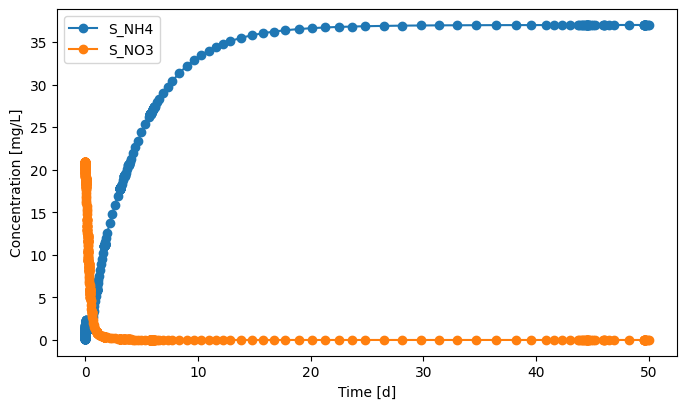

In [36]:
effluent.scope.plot_time_series(('S_NH4', 'S_NO3'))  # you can plot how each state variable changes over time

(<Figure size 800x450 with 1 Axes>,
 <Axes: xlabel='Time [d]', ylabel='Concentration [mg/L]'>)

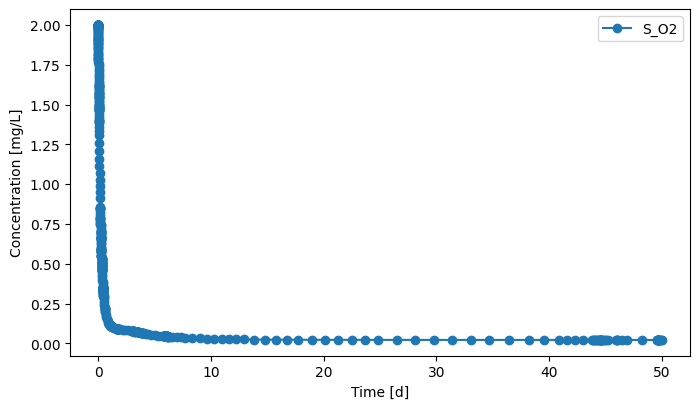

In [37]:
effluent.scope.plot_time_series(('S_O2'))  # you can plot how each state variable changes over time

(<Figure size 800x450 with 1 Axes>,
 <Axes: xlabel='Time [d]', ylabel='State Variable'>)

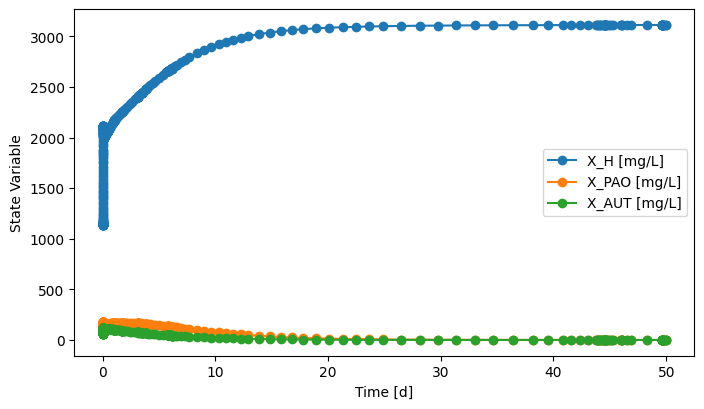

In [38]:
O3.scope.plot_time_series(('X_H', 'X_PAO', 'X_AUT'))  # you can plot how each state variable changes over time

[Back to top](#top)